# In Class Exercises

1. In AI, datasets are often very large and cannot be processed all at once as is done in the loop above. The data is instead randomly sampled in smaller _batches_ where each _batch_ contains `batch_size` inputs. How can you change the loop above to sample the dataset in smaller batches? Hint: Our `data` variable is a Pandas `DataFrame` object, search for "how to sample a DataFrame".

Answer: By changing the data 'collection' in the epoch loop to collect a subsample, e.g. `data_sample = data.sample(batch_size)`, a smaller batch can be obtained and used for the update of the linear fit parameters.


2. As described above, learning rates that grow smaller over time can help find and get closer to global minima. In the loop above, our `learning_rate_m` and `learning_rate_b` are constant through the process of minimizing our parameters. How could you change the loop to reduce the learning rates over loop iterations?

Answer: By changing the method of updating the learning rate. On each loop, scale the base learning rate by a normalization of the gradient to the maximal observed gradient thus far. This way, the initial learning rate is still taken into account, but if the gradient approaches a minimum, the step size is decreased.
In code:
`learning_scale_m = abs(dL_dm/dL_dm_max)`

`learning_rate_m = learning_rate_m_base * learning_scale_m`

`learning_scale_b = abs(dL_db/dL_db_max)`

`learning_rate_b = learning_rate_b_base * learning_scale_b`


# Homework

Follow the example from the previous notebook [Linear Regression using SGD](./01_linear_regression_sgd.ipynb) and build a loop that properly finds the centers of these 4 clusters using k-means.


# In class Exercises code

Imports

In [68]:
from random import randint, random, randrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time


Load data

In [69]:
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)


Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')


Plot with Matplotlib

Text(0, 0.5, 'Sale Price')

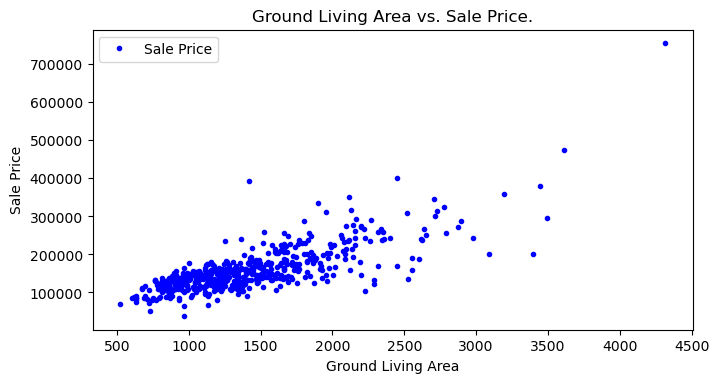

In [70]:
figure = plt.figure(figsize=(6, 3))
ax = figure.add_axes([1, 1, 1, 1])
ax.set_title("Ground Living Area vs. Sale Price.")
scatter = ax.plot(data.GrLivArea, data.SalePrice, '.b')
ax.legend(scatter, ["Sale Price"])
ax.set_xlabel("Ground Living Area")
ax.set_ylabel("Sale Price")


Manual regression

In [71]:
n = len(data)
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()
# Define components of regression coefficient.
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)
denominator = n * sum_x2 - sum_x * sum_x
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('Calculated linear fit: y = %f * x + %f' % (m, b))

# Saving these for later comparison.
m_calc = m
b_calc = b


Calculated linear fit: y = 87.688145 * x + 34754.077892


Define linear fit estimator.

In [72]:


def get_lin_fit(x, m, b):
    # The 'arange' function generates points between two limits (min,max)
    linear_x = np.arange(x.min(), x.max())
    # Now use fit parameters to calculate the y points based on x points.
    linear_y = linear_x * m + b
    return linear_x, linear_y


Define data plotting function.

In [73]:


def plot_data(x, y, m, b, ax):
    # Plot data points with 'bo' = blue circles.
    # Note that plot() returns tuples, so the comme disentangles that.
    scatter_plot, = ax.plot(x, y, 'bo')
    # Create the line based on linear fit parameters.
    linear_x, linear_y = get_lin_fit(x, m, b)
    # Plot the linear points using 'r-' = red line
    lin_plot, = ax.plot(linear_x, linear_y, 'r-')
    return scatter_plot, lin_plot


Define model.

In [74]:


def model(x, m, b):
    return m * x + b


Define loss function.

In [75]:


def loss(x, y, m, b):
    # Get predicted y-values from input and fit parameters.
    y_predicted = model(x, m, b)
    # Loss is the square of actual minus prediction, to obtain a smooth loss function.
    return np.power(y - y_predicted, 2)


Define parameter update (learning) functions.

In [76]:


def updated_m(x, y, m, b, learning_rate, do_scale=False):
    # Gradients of loss function to parameters are manually calculated.
    dL_dm = np.mean(- 2 * x * (y - model(x, m, b)))
    new_m = m - learning_rate * dL_dm
    return new_m, dL_dm


def updated_b(x, y, m, b, learning_rate, do_scale=False):
    # Gradients of loss function to parameters are manually calculated.
    dL_db = np.mean(- 2 * (y - model(x, m, b)))
    new_b = b - learning_rate * dL_db
    return new_b, dL_db


Define gradient descent loop.

In [77]:
def gd_loop(loop_n, data, batch_size, m, b, learning_rate_m, learning_rate_b, do_plot, do_scale):
    # Track history of loss over time.
    loss_history = []

    # Initialize learning rates for scaled learning.
    learning_rate_m_base = learning_rate_m
    learning_rate_b_base = learning_rate_b

    # Initialize max gradients for scaled learning.
    dL_dm_max = 1
    dL_db_max = 1

    for i in range(loop_n):

        # Convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price". Get a batch of B data points.
        data_sample = data.sample(batch_size)
        data_x = data_sample['GrLivArea'].to_numpy()
        data_y = data_sample['SalePrice'].to_numpy()

        # Update slope and intercept based on the current values.
        m, dL_dm = updated_m(data_x, data_y, m, b, learning_rate_m)
        b, dL_db = updated_b(data_x, data_y, m, b, learning_rate_b)

        if do_scale:
            # Update learning rates.
            dL_dm_max = max([dL_dm_max, abs(dL_dm)])
            dL_db_max = max([dL_db_max, abs(dL_db)])
            learning_scale_m = abs(dL_dm/dL_dm_max)
            learning_rate_m = learning_rate_m_base * learning_scale_m
            learning_scale_b = abs(dL_db/dL_db_max)
            learning_rate_b = learning_rate_b_base * learning_scale_b

        # Calculate the loss value for the new parameters.
        loss_value = np.mean(loss(data_x, data_y, m, b))

        # Store loss.
        loss_history.append(loss_value)

        if do_plot:
            # Print progress.
            print('[%03d] dy_i = %.2f * x + %.2f . Loss: %.1f'
            % (i, m, b, loss_value))
        
            # Create plot. Unfortunately, updating the plot isn't straightforward.
            # Create a 1 by 2 plot grid.
            fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

            # Plot prediction and original.
            scatter_plot, lin_plot = plot_data(data_x, data_y, m, b, ax[0])
            ax[0].set_xlabel('Ground Living Area')
            ax[0].set_ylabel('Sale Price')

            # Here we also plot the calculated linear fit for comparison
            calc_x = np.arange(data_x.min(), data_x.max())
            calc_y = calc_x * m_calc + b_calc
            ax[0].plot(calc_x, calc_y, 'b-')
            ax[0].legend(["Data", "Learned Linear Fit", "Manual Linear Fit"])

            # Plot the loss.
            loss_x = np.arange(0, len(loss_history))
            loss_y = np.asarray(loss_history)
            ax[1].clear()
            ax[1].plot(loss_x, loss_y)
            ax[1].set_yscale('log')
            ax[1].set_xlabel('loop step')
            ax[1].set_ylabel('loss')
            ax[1].legend(["Loss"])
            plt.show()
            # Gives us time to see the plot
            time.sleep(0.01)
            # Clears the terminal output when the next plot is ready to show.
            ipydis.clear_output(wait=True)
    return loss_history, m, b



## Unscaled learning

In [78]:
# Initialize with random slope and intercept.
m = randrange(1, 25)
b = randrange(100, 10000, 100)

batch_size = 60
# Set a learning rate for each parameter individually.
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# Run for n epochs.
loop_n = 30

# Set plotting and scaling toggles.
do_plot = False
do_scale = False

loss_history, m, b = gd_loop(loop_n, data, batch_size, m, b, learning_rate_m, learning_rate_b, do_plot, do_scale)



Plot unscaled learning results.

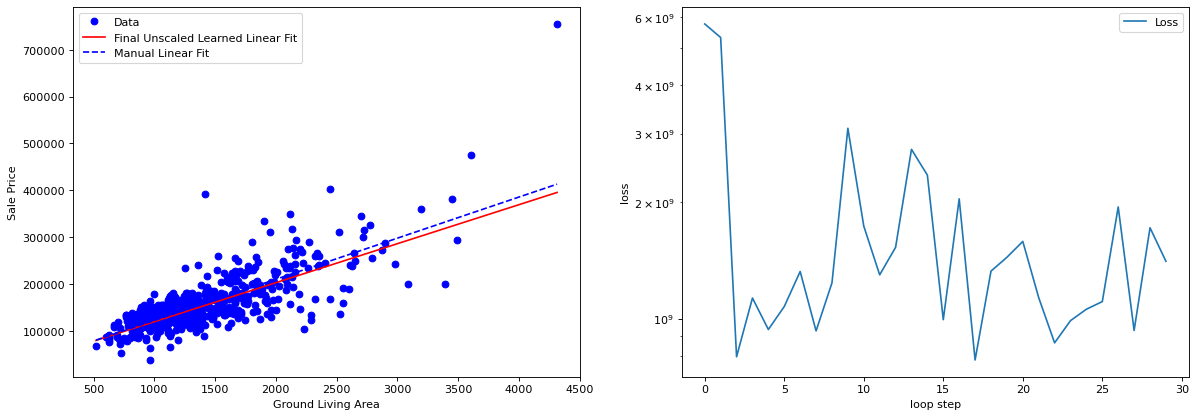

In [79]:
# Plot final learned fit vs manual fit.
# Create plot. Unfortunately, updating the plot isn't straightforward.
# Create a 1 by 2 plot grid.
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# Plot prediction and original.
scatter_plot, lin_plot = plot_data(x, y, m, b, ax[0])
ax[0].set_xlabel('Ground Living Area')
ax[0].set_ylabel('Sale Price')

# Here we also plot the calculated linear fit for comparison
lin_x, lin_y = get_lin_fit(x, m_calc, b_calc)
ax[0].plot(lin_x, lin_y, 'b--')
ax[0].legend(["Data", "Final Unscaled Learned Linear Fit", "Manual Linear Fit"])

loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].clear()
ax[1].plot(loss_x, loss_y)
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')
ax[1].legend(["Loss"])



## Scaled learning

In [80]:
# Initialize with random slope and intercept.
m = randrange(1, 25)
b = randrange(100, 10000, 100)

batch_size = 60
# Set initial learning rate for each parameter individually.
learning_rate_m = 1e-7
learning_rate_b = 1e-1

# Run for n epochs.
loop_n = 500

# Set plotting and scaling toggles.
do_plot = False
do_scale = True

loss_history, m, b = gd_loop(loop_n, data, batch_size, m, b, learning_rate_m, learning_rate_b, do_plot, do_scale)



Plot scaled learning results.

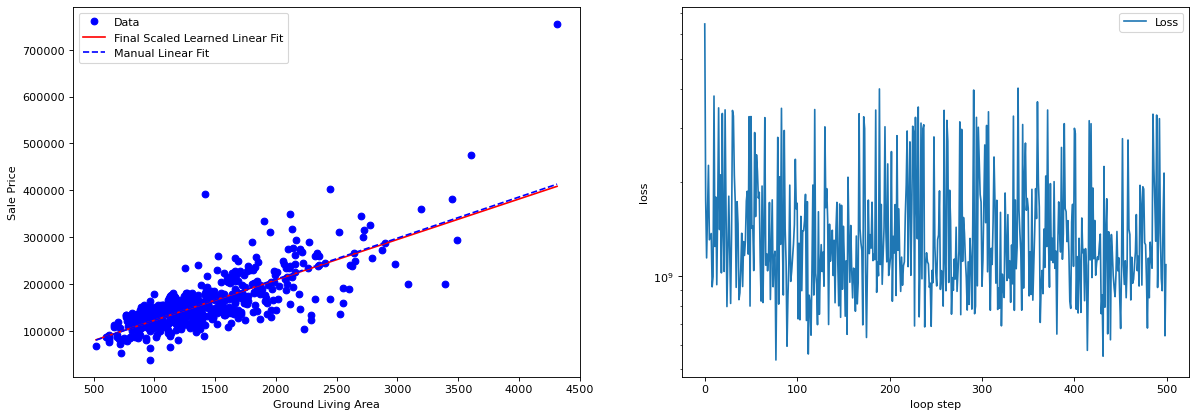

In [81]:
# Plot final learned fit vs manual fit.
# Create plot. Unfortunately, updating the plot isn't straightforward.
# Create a 1 by 2 plot grid.
fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=80)

# Plot prediction and original.
scatter_plot, lin_plot = plot_data(x, y, m, b, ax[0])
ax[0].set_xlabel('Ground Living Area')
ax[0].set_ylabel('Sale Price')

# Here we also plot the calculated linear fit for comparison
lin_x, lin_y = get_lin_fit(x, m_calc, b_calc)
ax[0].plot(lin_x, lin_y, 'b--')
ax[0].legend(["Data", "Final Scaled Learned Linear Fit", "Manual Linear Fit"])

loss_x = np.arange(0, len(loss_history))
loss_y = np.asarray(loss_history)
ax[1].clear()
ax[1].plot(loss_x, loss_y)
ax[1].set_yscale('log')
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('loss')
ax[1].legend(["Loss"])





# Homework: K-means clustering code

Imports

In [82]:
from sklearn.datasets import make_blobs
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
import IPython.display as ipydis


Definitions

In [83]:


def initialize_centroids(x, N):
    """Initialize centroids as a random selection of 4 points from all available cluster points."""
    x_indices = np.random.choice(np.arange(0, x.shape[0]), N)
    centroids = x[x_indices]
    return centroids


def get_new_centroids(x, labels, N_clusters):
    """returns the new centroids assigned from the points closest to them"""
    # Get the average x1 and x2 (axis=0 so vertical) coordinate of all cluster points with a given label.
    centroids = [x[labels == this_cluster].mean(
        axis=0) for this_cluster in range(N_clusters)]
    # Cast centroids to an Nx2 array.
    return np.array(centroids)


def assign_labels(x, c):
    """Assign labels based on datapoints x and centroids c."""
    # Distance is sqrt( (x - x')**2 + (y - y')**2 )
    # Centroids are shape [N,2]
    # x is shape [npoints,2]
    # Add middle index to centroids to properly broadcast in math operations.
    c = c[:, np.newaxis, :]  # [N,1,2]

    # Calculate (x - x')**2 and (y - y')**2
    # x is shape [npoints,2], c is [N,1,2], results in an array of shape: [N,npoints,2]
    dist2 = (x - c)**2

    # Calculate (x - x')**2 + (y - y')**2
    dist2 = dist2.sum(axis=2)  # [N,npoints]

    # Out of the N distances, return the index (0-(N-1)) of the one that is the minimum distance away.
    label = np.argmin(dist2, axis=0)  # [npoints]

    return label


def get_centroid_distance(true_centers, estimated_centers):
    """Get distance from true centers to estimated centers."""
    # For each cluster in estimated_centers, calculate the euclidian distance to each true center and pick the smallest. Returns an array of N shortest distances.
    all_distances = []

    for this_estimated in range(estimated_centers.shape[0]):
        # Get coordinates of this estimated centroid.
        this_center = estimated_centers[this_estimated, :]
        distances = np.sqrt(np.sum([np.power(this_center - true_centers[this_true, :], 2)
                            for this_true in range(true_centers.shape[0])], axis=1))
        all_distances.append(min(distances))

    return all_distances




Create clusters.

In [84]:
# Create n points per cluster.
npoints = 500
# Create N clusters.
N = 4
# Use make_blobs from sklearn to create the cluster points. This returns a list of nx2 coordinates for the cluster points, nx1 labels, and Nx2 coordinates for centers.
x, true_labels, true_centers = make_blobs(n_samples=npoints, centers=N,
                                          cluster_std=0.60, random_state=0,
                                          return_centers=True)


Show true labels.

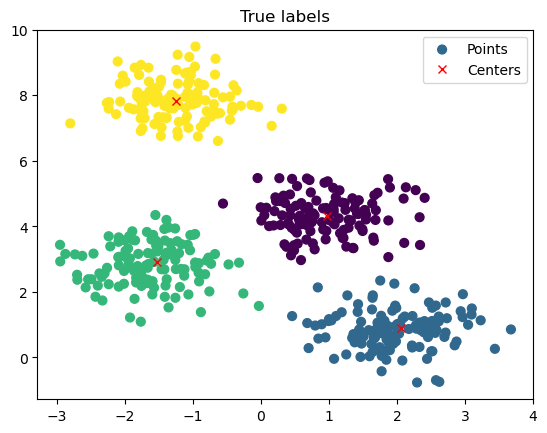

In [85]:
# Show the original cluster and their centers.
plt.scatter(x[:, 0], x[:, 1], c=true_labels, s=40, cmap='viridis')
plt.plot(true_centers[:, 0], true_centers[:, 1], 'rx')
plt.legend(["Points", "Centers"])
plt.title('True labels')
if hasattr(sys, 'ps1'):  # True if interactive.
    plt.show()
else:
    # Run from terminal.
    plt.savefig('img/Truth.png', format='png')
    plt.cla()  # Clear axes to avoid ghosting.


Initialize estimate.

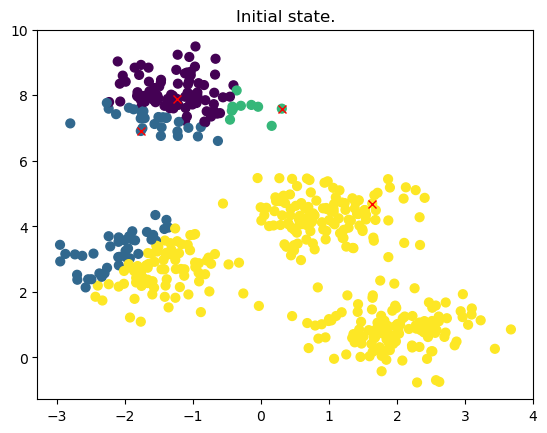

In [86]:
# Initialize random centroids and labels.
last_centroids = initialize_centroids(x, N)
last_labels = assign_labels(x, last_centroids)
plt.scatter(x[:, 0], x[:, 1], c=last_labels, s=40, cmap='viridis')
plt.plot(last_centroids[:,0], last_centroids[:,1],'rx')
plt.title("Initial state.")
if hasattr(sys, 'ps1'):  # True if interactive.
    plt.show()
else:
    # Run from terminal.
    plt.savefig('img/Step_.png', format='png')
    plt.cla()  # Clear axes to avoid ghosting.


Loop parameters.

In [87]:
delta = 0.001
epochs = 20
do_break = False


Estimation loop.

Centroids unchanged as of step 7.


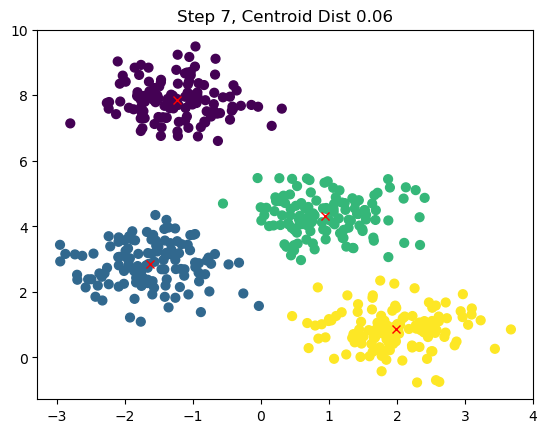

In [88]:
# Make a loop that performs k-means clustering.

for step in range(epochs):
    # Get newest centroid positions, and re-calculate labels.
    estimated_centroids = get_new_centroids(x, last_labels, N)  
    estimated_labels = assign_labels(x, estimated_centroids)

    # Test if centroids have stopped moving. If not, update the labels and plot one last time and break the loop.
    dists = last_centroids - estimated_centroids
    if np.all(dists < delta):
        print('Centroids unchanged as of step %d.' % step)
        estimated_labels = assign_labels(x, estimated_centroids)
        if np.all(estimated_labels == last_labels):
            do_break = True
        
    # Save labels and centroids for next run.
    last_labels = estimated_labels
    last_centroids = estimated_centroids

    # Instead of defining accuracy by labels, determine the average distance between the estimated and the true centroids.
    all_distances = get_centroid_distance(true_centers, estimated_centroids)

    # Plot newest estimation.
    plt.scatter(x[:, 0], x[:, 1], c=last_labels, s=40, cmap='viridis')
    plt.plot(estimated_centroids[:, 0], estimated_centroids[:, 1], 'rx')
    plt.title('Step %d, Centroid Dist %.2f' %
              (step, np.mean(all_distances)))
    if hasattr(sys, 'ps1'):  # True if interactive.
        plt.show()
    else:
        # Run from terminal.
        plt.savefig('img/Step_%d.png' % (step), format='png')
        plt.cla()  # Clear axes to avoid ghosting.

    # If centroids stopped moving, break.
    if do_break:
        break

    time.sleep(0.5)
    # Clears the terminal output when the next plot is ready to show.
    if hasattr(sys, 'ps1'):  # True if interactive.
        ipydis.clear_output(wait=True)

# plt.show()